# notebook n02: Freezing/Darting Detection

Jose Oliveira da Cruz, PhD  | LeDoux Lab  
jose.cruz@nyu.edu  

<img src="https://misophoniainternational.com/wp-content/uploads/2016/04/LedouxLab.jpg" style="width: 200.464px; height: 200px; margin: 0px;">

This notebooks takes data files from nb01_transform_dlc_output (i.e. ``_individual_preprocessing_dlc.csv``) and:

A) Perform motion analysis

1. Load deeplabcut data
2. Fetch information about specific animal
3. Create new empty dataframe to hold the results
4. Freezing detector: Calculate freezing events based on euclidean distance
5. Darting detector
6. Save the data


*Currently being developed: head_direction detector*  



B) Motion analysis visualization

1.


# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, correlate
import os
import sys
from scipy.interpolate import interp1d
from scipy import stats
import time
import glob
import importlib
import warnings


# Import my code
sys.path.append(r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\src')
from tools.utils.organization import *
from analysis.motion_analysis import *
from analysis.freezing_analysis import *
from visualization import *
from visualization.plot_events import *


In [1]:
# Import dependencies
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, correlate
import os
import sys


# Import my code
sys.path.append(r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\src')
from tools.utils.organization import *
from analysis.motion_analysis import *
from analysis.freezing_analysis import *
from visualization import *
from visualization.plot_events import *


## Specify where to save the data for each step (see above, A and B)

In [2]:
step_a_save_dir = r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\data\interim\EXP004\motion_analysis_dlc'

print(f'Does the directory exist? \n a: {os.path.isdir(step_a_save_dir)}') 

Does the directory exist? 
 a: True


# Step A: Perform Motion Analysis (so far: freezing and darting)

## 1) Load `_individual_preprocessing_dlc.csv`

In [ ]:
# Open dataframe

dpath = r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\data\interim\EXP004\individual_preprocessing_dlc'
fpath = 'jc_exp004_20200110_tes01_r_286600_t00_individual_preprocessing_dlc.csv'

print(f'File exists?\n- {os.path.isfile(os.path.join(dpath, fpath))}')

In [265]:
# Load data
dataframe = pd.read_csv(
    
    os.path.join(dpath, fpath),
    index_col=0,
    
)

# Inspect dataframe
display(dataframe.head())

,user,exp_id,treatment,session,species,animal_id,session.1,cs_id,cs_epoch,ed_between_eyes,...,ed_tail_start,ed_head,speed_between_eyes,speed_upper_torso,speed_ear_left,speed_ear_right,speed_snout,speed_medium_torso,speed_tail_start,speed_head
1,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0.053482,...,0.028419,0.071064,1.604452,4.743722,3.062891,2.207633,2.111145,5.501756,0.852568,2.131927
2,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0.052604,...,0.030065,0.095959,1.578107,2.710574,3.981599,2.009457,2.328639,0.736909,0.901937,2.878760
3,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0.151493,...,0.051288,0.139623,4.544802,5.181223,4.256061,1.851936,4.762084,0.264307,1.538644,4.188688
4,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0.029928,...,0.005432,0.064404,0.897849,9.193181,2.215045,1.276443,0.586244,6.605660,0.162962,1.932118
5,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0.090604,...,0.020646,0.175430,2.718119,1.895230,5.186983,1.527428,8.203307,4.509290,0.619378,5.262901


## 2) Fetch information about a specific rat

The code bellow will read the video key( e.g `JC_EXP005_20200124_TES01_R_287073_T00`) and search for the complete information about this specific animal.  
Then it creates an instance of the Animal class with the complete information of the animal.

### 2.1) Load Global Animal Record and Experiment information

In [266]:
# Where is the main record?
main_record_directory = r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\animal_record\main_record'
main_record_basename = 'main_record_20200325_151527.csv'

main_record = os.path.join(main_record_directory,
                           main_record_basename)

In [267]:
# Where is the information about the experiment?
experiment_info_directory = r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\data\interim\EXP004\bonsai_extraction_led_epochs_frame_rate'
experiment_info_basename = 'JC_EXP004_20200110_TES01_cs_index_plus_frame_rate.csv'
experiment_info = os.path.join(experiment_info_directory,
                               experiment_info_basename)

### 2.2) Fetch animal information

In [268]:
# Search object with regular expressions
pattern = r'(\w\w_\w\w\w\d\d\d_\d\d\d\d\d\d\d\d_\w\w\w\d\d_\w_\d\d\d\d\d\d_\w\d\d)'
video_key = re.search(pattern, fpath).group()

# Fetch information
rat = fetch_animal_info(
    video_key, 
    main_record, 
    experiment_info,
)

## 3) Create new empty dataframe to hold the results

In [269]:
columns = ['user', 'exp_id', 'treatment', 'session', 'species', 'animal_id', 'session', 'cs_id', 'cs_epoch']

motion_dataframe = dataframe.copy()[columns]

motion_dataframe.head()

,user,exp_id,treatment,session,species,animal_id,session,cs_id,cs_epoch
1,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs
2,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs
3,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs
4,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs
5,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs


## 4) Freezing Detector

The freezing detector uses:
1. Four bodyparts: between_eyes, head, ear_right and ear_left 
2. Euclidean distance between 2 consecutive points for each frame. Bellow threshld, it is considered immobility
3. Consider only events with minimum of 0.5 second of freezing (==15 frames)  

### 4.1) Define Variables

In [270]:
# Define bodyparts
bodyparts = ['head', 'ear_right', 'ear_left', 'between_eyes']
motion_threshold = 0.20 # in cmarray_to_return
min_freezing_duration = 15 # minimum duration in frames, for 30fps == 0.5 second

### 4.2) Extract Freezing

In [271]:
freezing_array = extract_freezing_events(dataframe, bodyparts, motion_threshold, min_freezing_duration)

### 4.3) Update the dataframe with freezing event

In [272]:
motion_dataframe['freezing_events'] = freezing_array
motion_dataframe.head()

,user,exp_id,treatment,session,species,animal_id,session,cs_id,cs_epoch,freezing_events
1,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0
2,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0
3,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0
4,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0
5,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0


## 5) Darting Detector

Darting must respect 2 conditions: 
1. Increased in speed higher than `mean` + `1*std` of the raw signal and,
2. Cumulative distance of more than `15 cm` during the events detected in 1).

### 5.1) Define variables and conditions


In [273]:
# Define thresholds
threshold_speed = calculate_threshold(dataframe['speed_head'], factor=1)

# Distance coverted during an event
threshold_distance = 15 # cm

# Data to calculate 
speed_array = savgol_filter(dataframe['speed_head'].to_numpy(), window_length=9, polyorder=1)
distance_array = dataframe['ed_head'].to_numpy()


### 5.2) Extract Darting

In [274]:
darting_array, darting_list_index = extract_darting_events(
    speed_array,
    distance_array,
    threshold_speed,
    threshold_distance,
)

### 5.3) Update the dataframe with darting events

In [275]:
motion_dataframe['darting_events'] = darting_array
motion_dataframe.head(5)

,user,exp_id,treatment,session,species,animal_id,session,cs_id,cs_epoch,freezing_events,darting_events
1,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0,0
2,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0,0
3,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0,0
4,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0,0
5,JC,exp004,NaN,tes01,rat,286600,tes01,cs_01,pre_cs,0,0


## 6) Save data

In [276]:
saving_basename = f'{rat.video_basename}_motion_analysis_dlc.csv'.lower()

motion_dataframe.to_csv(os.path.join(step_a_save_dir, saving_basename))

# Step B: Visualization of motion_analysis

## 1) Visualize freezing events

This step is used to visually inspect the data

1.1) Define the 

In [277]:
# Define the cs to plot
cs_id_list = motion_dataframe['cs_id'].unique()
cs_id_list

array(['cs_01', 'cs_02', 'cs_03', 'cs_04', 'cs_05'], dtype=object)

### 8.1) Freezing raster plot

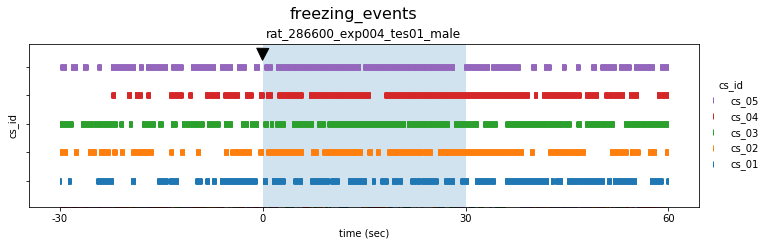

In [278]:
freezing_raster, ax = plt.subplots(figsize=(12, 3))

plot_events(
    ax,
    motion_dataframe, 
    cs_id_list,
    rat, 
    event_type='freezing',
)

event_type='freezing'
freezing_raster.suptitle(f'{event_type}_events', y=1.05, fontsize=16)
plt.show()

### 8.2) Darting raster plot

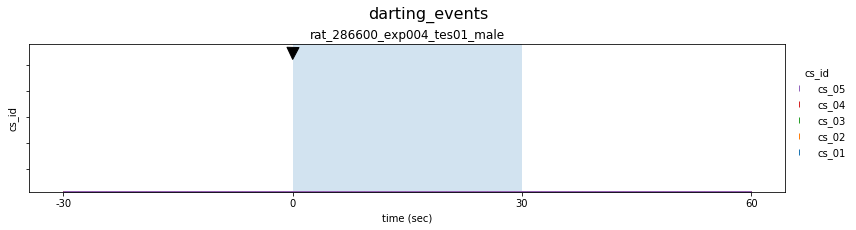

In [279]:
darting_raster, ax = plt.subplots(figsize=(12, 3))

plot_events(
    ax,
    motion_dataframe, 
    cs_id_list,
    rat, 
    event_type='darting',
)

event_type='darting'
darting_raster.suptitle(f'{event_type}_events', y=1.05, fontsize=16)
plt.tight_layout()

## 9) Save the data as 

Where to save? 

### 9.1) Freezing raster plot

In [280]:
saving_basename = f'{rat.video_basename}_freezing_raster_plot.pdf'.lower()
freezing_raster.savefig(os.path.join(step_a_save_dir, saving_basename), bbox_inches='tight')

### 9.2) Darting raster plot

In [281]:
saving_basename = f'{rat.video_basename}_darting_raster_plot.pdf'.lower()
darting_raster.savefig(os.path.join(step_a_save_dir, saving_basename), bbox_inches='tight')